In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from scipy.signal import medfilt
from scipy.ndimage import median_filter
# Cuidado al usar Prophet. De-registra los convertores de pandas para matplotlib, ocasionando bugs.
from fbprophet import Prophet
from sklearn import svm

C:\Users\ariel\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\ariel\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\ariel\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\ariel\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\ariel\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 19

In [2]:
pd.plotting.register_matplotlib_converters() # Volvemos a registrar los convertores.
plt.rcParams['figure.figsize'] = [16, 4]

In [3]:
def median_outlier_detection(ds, th=5, window=5):
    rolling_median = ds.rolling(window, center=True).median()
    absolute_deviation = (ds - rolling_median).abs()
    spikes = (absolute_deviation > th)
    return spikes

In [4]:
orig_weather = pd.read_csv("../data/pronóstico_horario_abril_sept.csv", parse_dates=["fecha"], index_col="fecha")

In [5]:
weather = orig_weather.copy()

In [6]:
weather.head()

,temp,hum,presion,dir,vel,nub,prec,t_max,t_min,situacion,faltante
fecha,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,E,14.8,6.0,0.0,28.9,18.7,Nuboso,False
2019-04-01 01:00:00,19.2,93.0,1016.7,E,9.4,4.0,0.0,20.1,12.5,Nubes dispersas,False
2019-04-01 02:00:00,18.5,95.0,1016.7,E,3.6,0.0,0.0,20.1,12.5,Despejado,False
2019-04-01 03:00:00,15.2,96.0,1016.7,S,5.4,0.0,0.0,20.1,12.5,"Despejado, neblina",False
2019-04-01 04:00:00,16.2,95.0,1016.3,E,7.6,4.0,0.0,20.1,12.5,"Nubes dispersas, neblina",False


In [7]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3764 entries, 2019-04-01 00:00:00 to 2019-09-04 19:00:00
Data columns (total 11 columns):
temp         3687 non-null float64
hum          3681 non-null float64
presion      3686 non-null float64
dir          3691 non-null object
vel          3691 non-null float64
nub          3691 non-null float64
prec         3691 non-null float64
t_max        3684 non-null float64
t_min        3684 non-null float64
situacion    3691 non-null object
faltante     3764 non-null bool
dtypes: bool(1), float64(8), object(2)
memory usage: 327.1+ KB


In [8]:
weather.describe()

,temp,hum,presion,vel,nub,prec,t_max,t_min
count,3687.000000,3681.000000,3686.000000,3691.000000,3691.000000,3691.000000,3684.000000,3684.000000
mean,9.457581,76.735126,1018.330141,13.333893,3.901653,0.144947,12.909148,4.718865
std,5.777448,21.062696,6.876680,9.701232,3.151689,2.117870,5.563179,4.930894
min,-20.200000,16.000000,999.000000,0.000000,0.000000,0.000000,-1.400000,-8.000000
25%,5.300000,63.000000,1013.900000,7.400000,0.000000,0.000000,9.200000,1.300000
50%,9.200000,83.000000,1018.300000,11.200000,4.000000,0.000000,12.600000,4.400000
75%,13.400000,93.000000,1022.900000,18.400000,7.000000,0.000000,17.000000,8.500000
max,28.600000,343.000000,1058.900000,129.700000,9.000000,62.000000,29.500000,24.000000


In [9]:
weather = weather.asfreq("H")

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


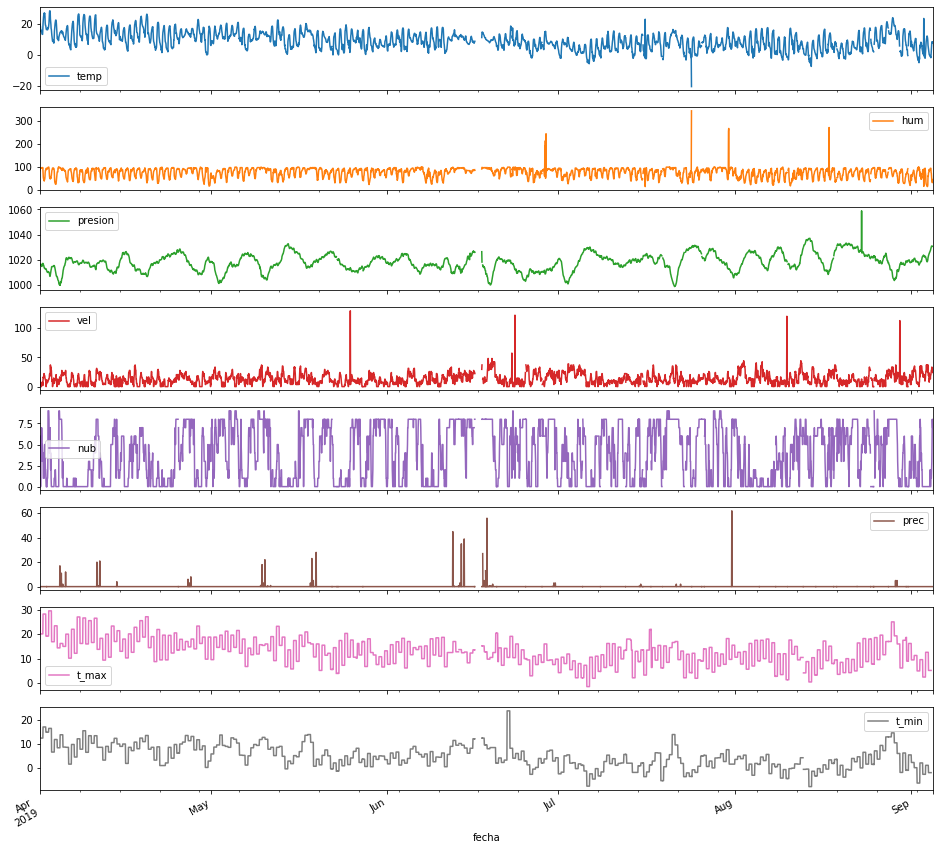

In [10]:
weather.plot(subplots=True, figsize=(16,16));

In [11]:
weather.isna().sum()

temp         77
hum          83
presion      78
dir          73
vel          73
nub          73
prec         73
t_max        80
t_min        80
situacion    73
faltante      0
dtype: int64

In [147]:
weather.loc[:, "hora"] = weather.index.hour
weather.loc[:, "dia"] = weather.index.day
weather.loc[:, "mes"] = weather.index.month

In [118]:
weather = weather.loc[weather.mes != 9, :].copy() # Removemos septiembre porque tiene pocos datos.

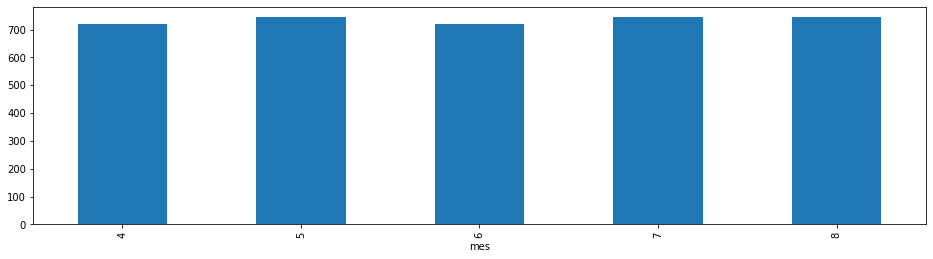

In [121]:
weather.groupby("mes").size().plot(kind="bar")

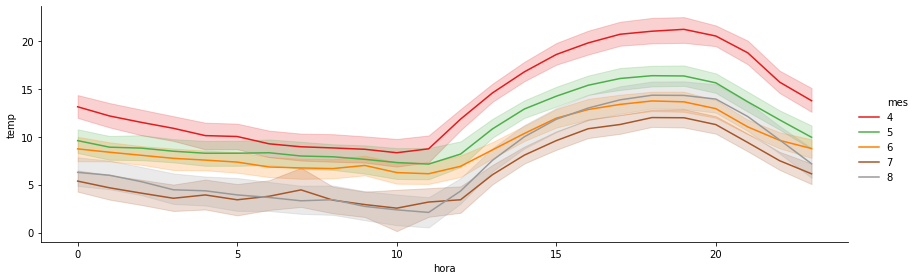

In [119]:
sns.relplot(y="temp", x="hora", hue="mes", data=weather, 
            height=4, aspect=3, kind="line", 
            ci=95, palette="Set1", legend="full")

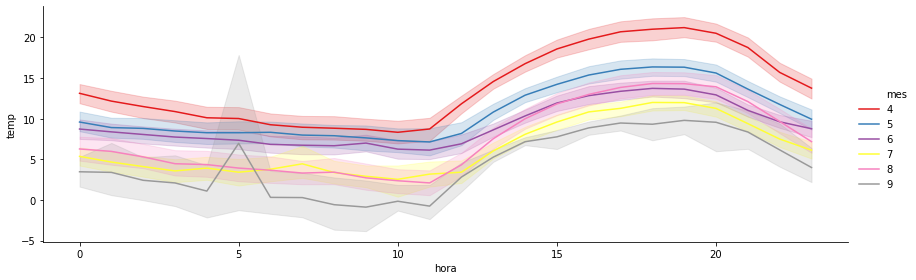

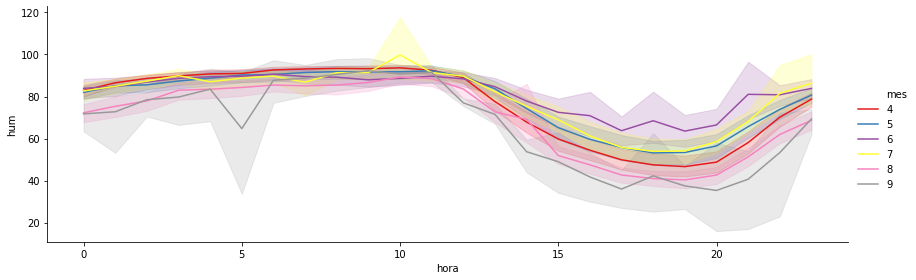

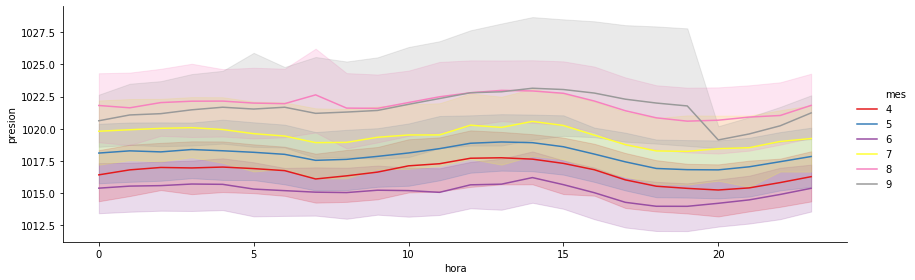

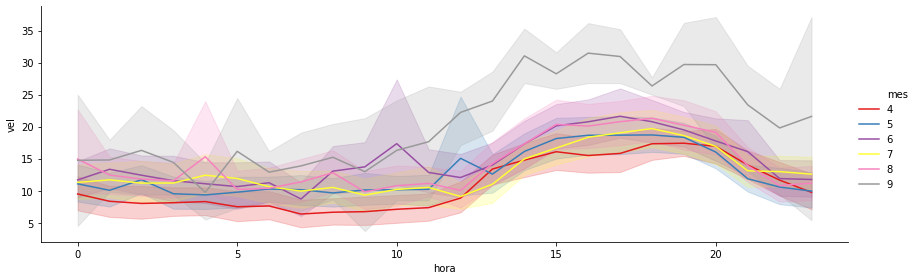

In [207]:
for var in numerical:
    sns.relplot(y=var, x="hora", hue="mes", data=weather,
                height=4, aspect=3, kind="line",
                ci=95, palette="Set1", legend="full")

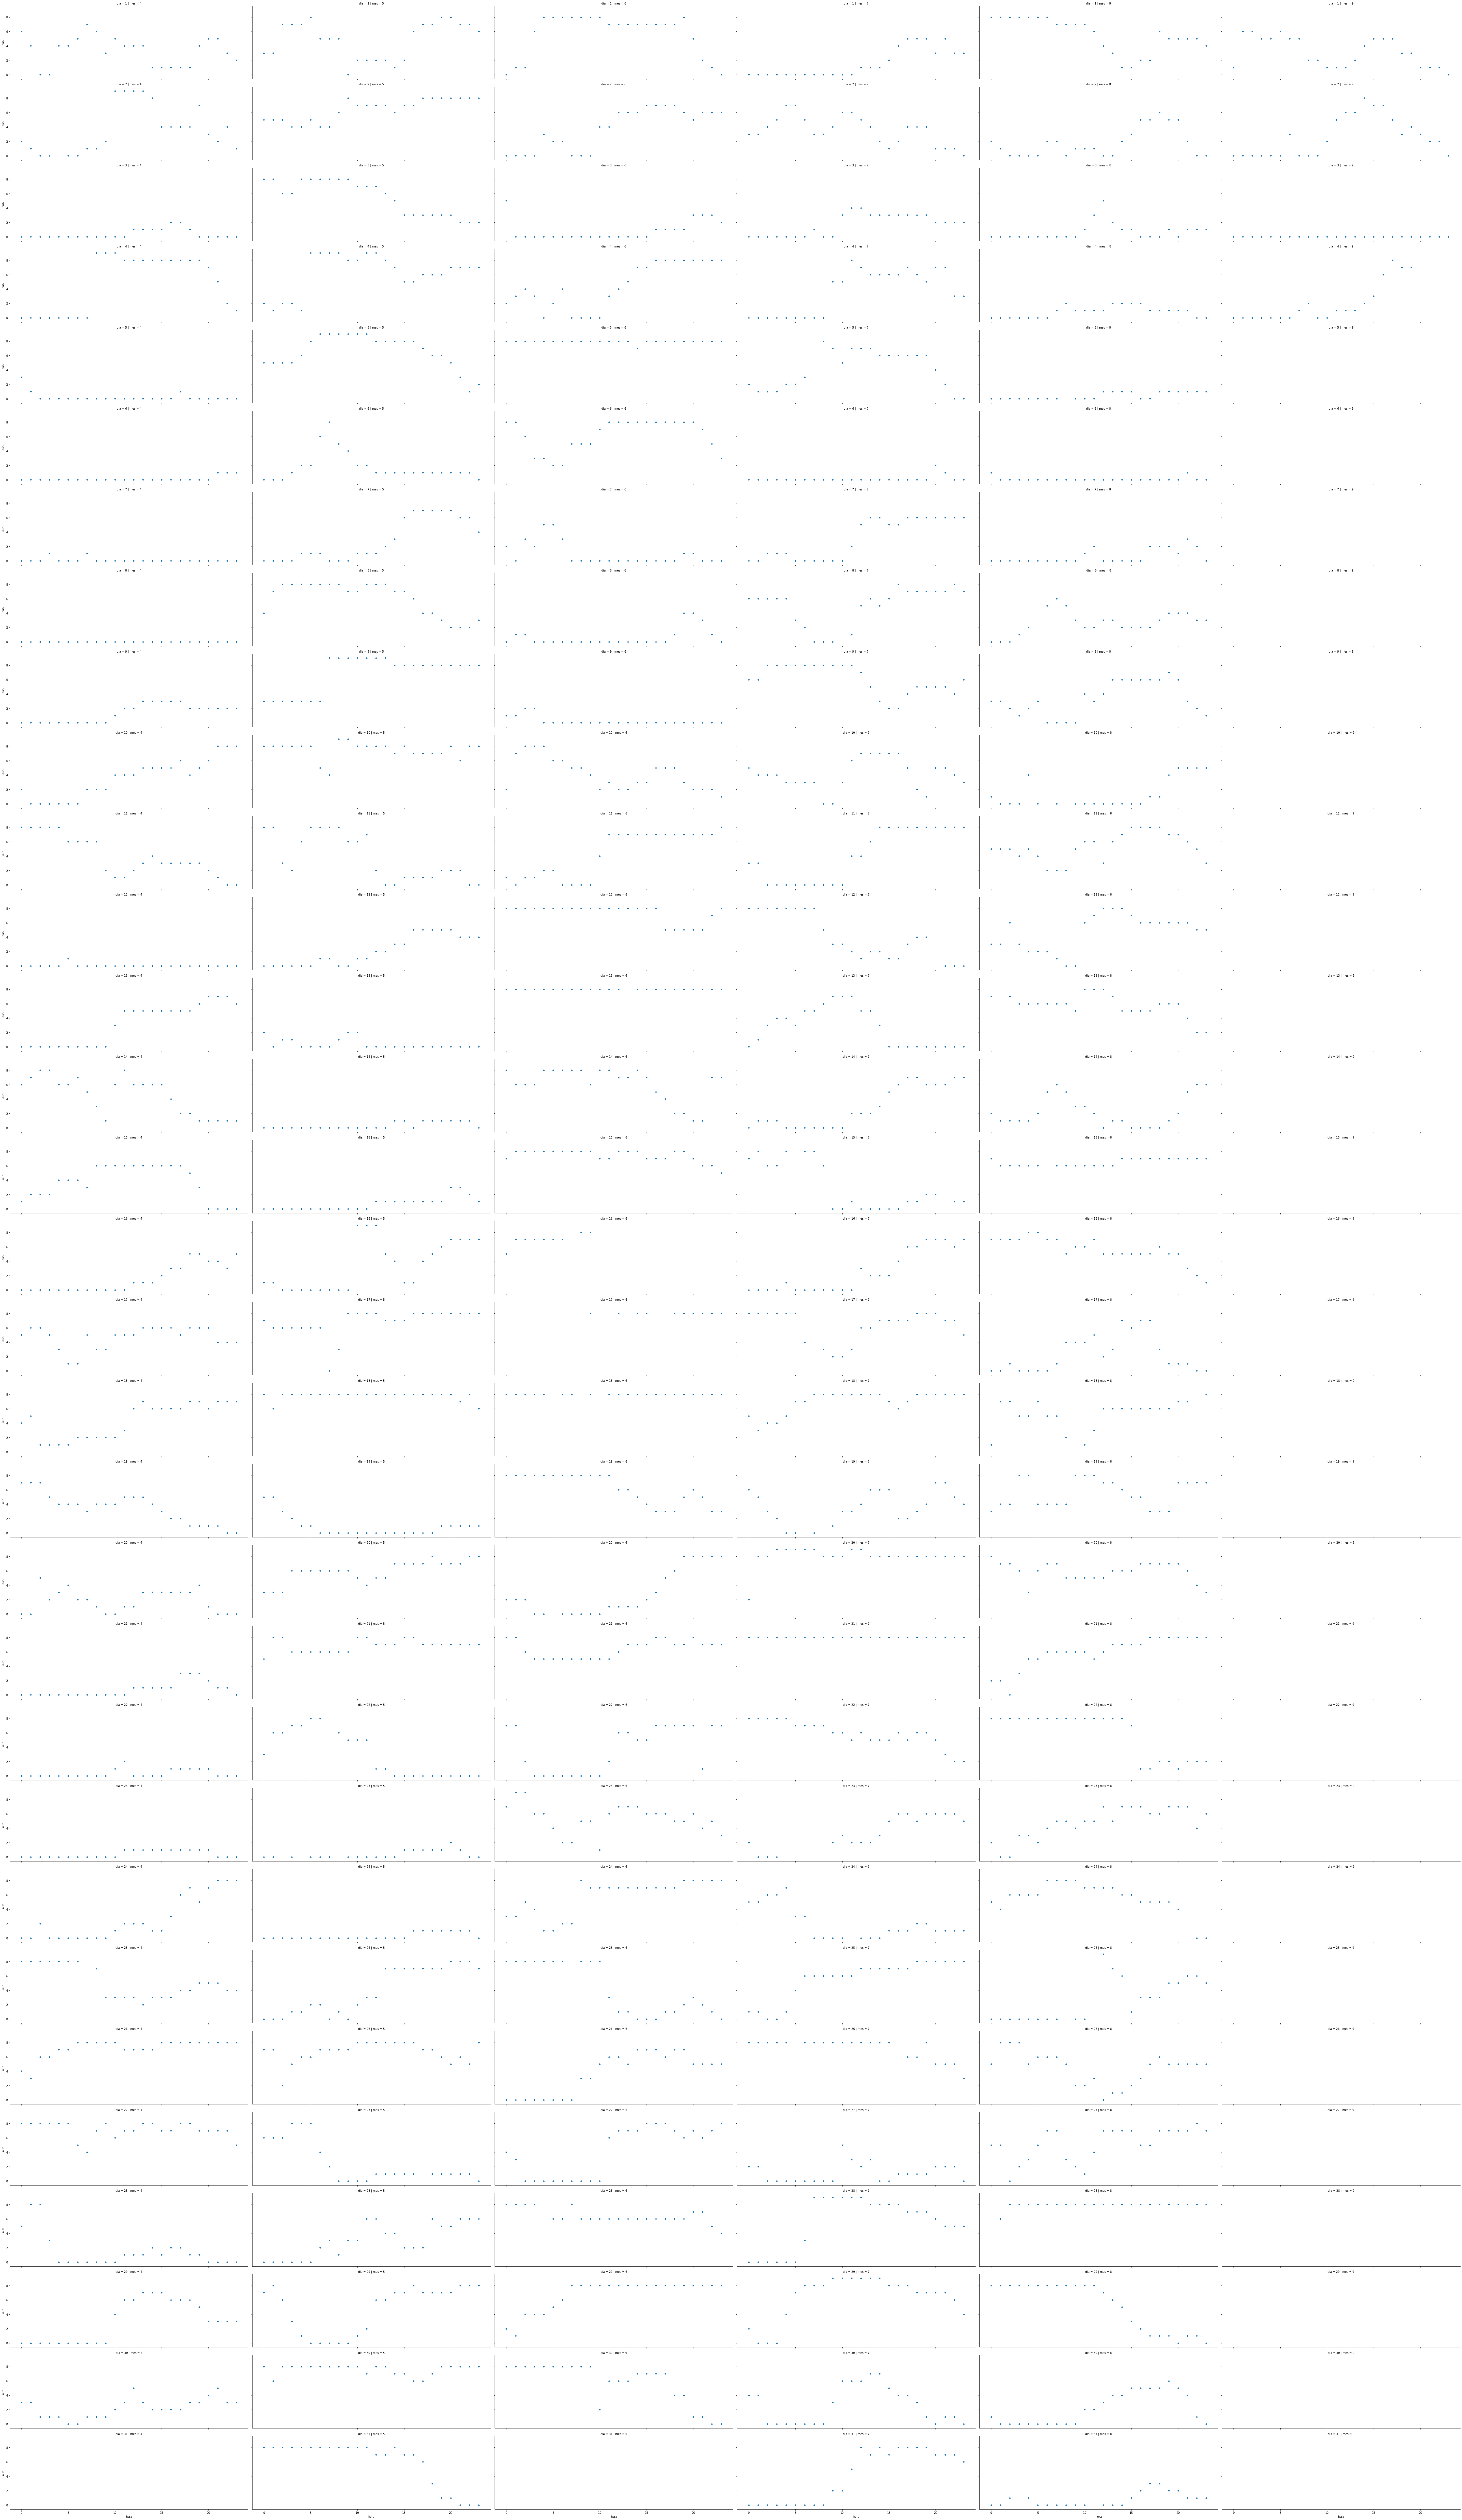

In [211]:
sns.relplot(y="nub", x="hora", row="dia", col="mes", data=weather, height=4, aspect=3, kind="scatter")

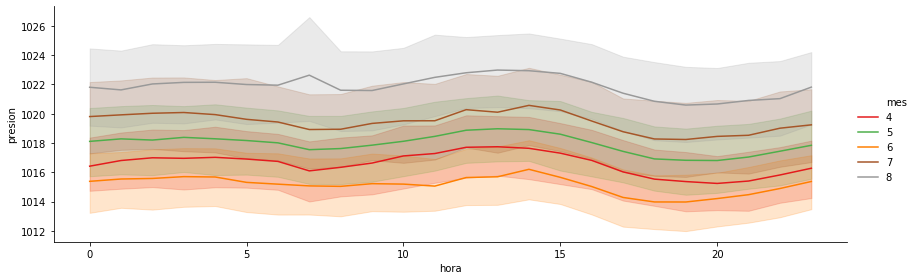

In [120]:
sns.relplot(y="presion", x="hora", hue="mes", data=weather, 
            height=4, aspect=3, kind="line", 
            ci=95, palette="Set1", legend="full")

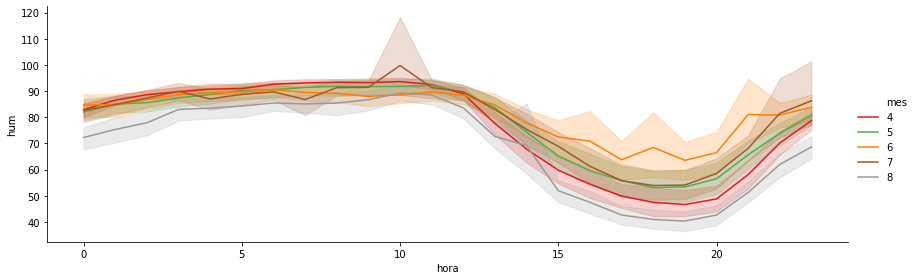

In [101]:
sns.relplot(y="hum", x="hora", hue="mes", data=weather, 
            height=4, aspect=3, kind="line", 
            ci=95, palette="Set1", legend="full")

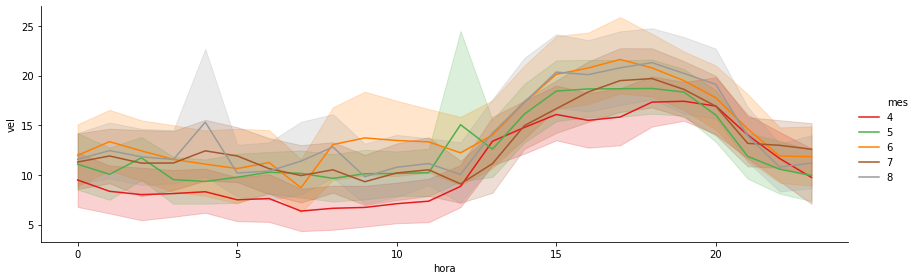

In [103]:
sns.relplot(y="vel", x="hora", hue="mes", data=weather, 
            height=4, aspect=3, kind="line", 
            ci=95, palette="Set1", legend="full")

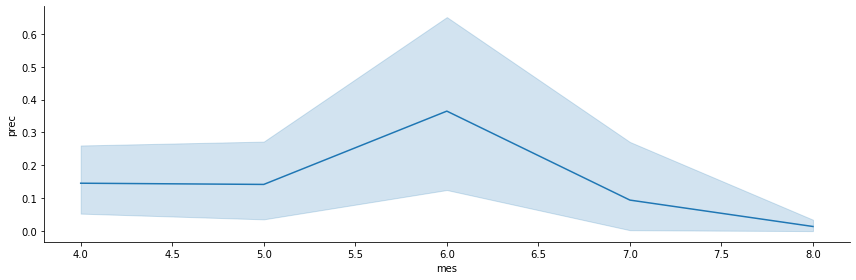

In [104]:
sns.relplot(y="prec", x="mes", data=weather, 
            height=4, aspect=3, kind="line", 
            ci=95, palette="Set1", legend="full")

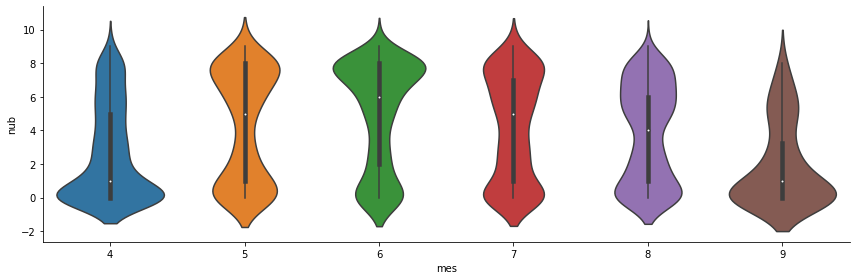

In [167]:
sns.catplot(x="mes", y="nub", data=weather, kind="violin", height=4, aspect=3)

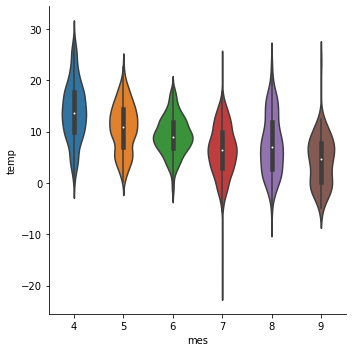

In [168]:
sns.catplot(x="mes", y="temp", data=weather, kind="violin")

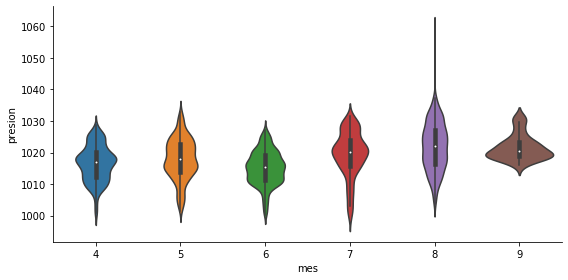

In [184]:
sns.catplot(x="mes", y="presion", data=weather, kind="violin", aspect=2, height=4)

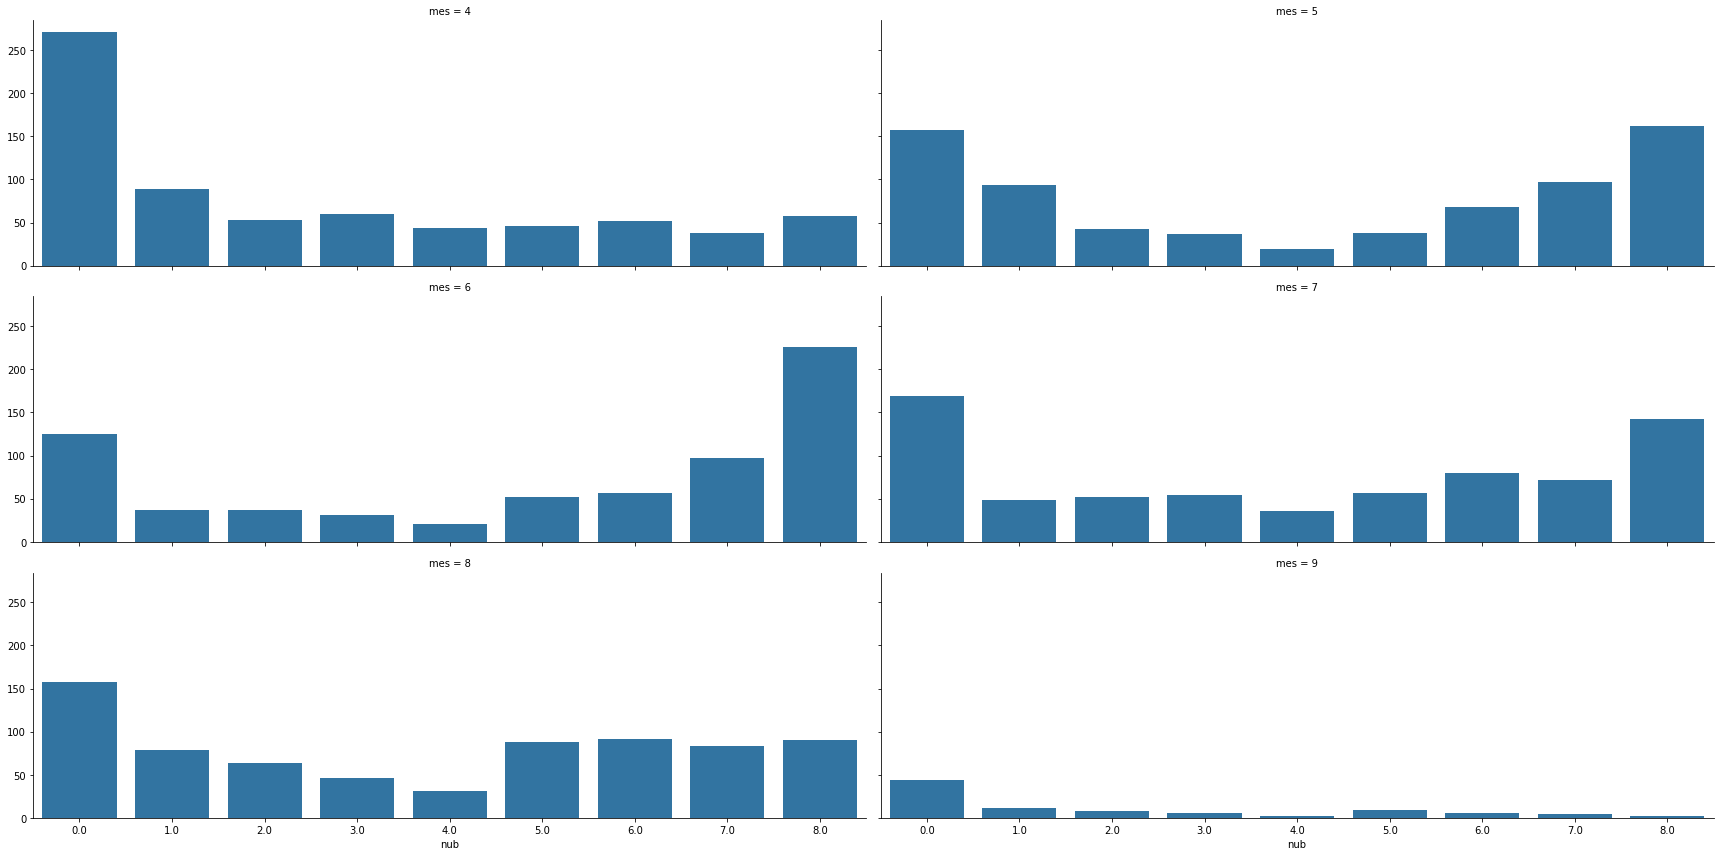

In [181]:
grid = sns.FacetGrid(col="mes", data=weather, aspect=3, height=4, col_wrap=2)
grid.map(sns.countplot, "nub")

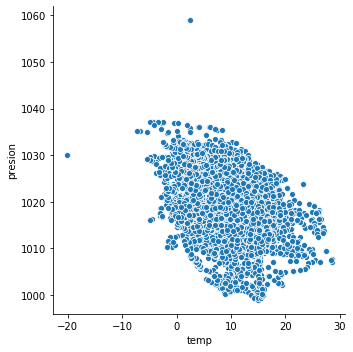

In [188]:
sns.relplot("temp", "presion", data=weather)

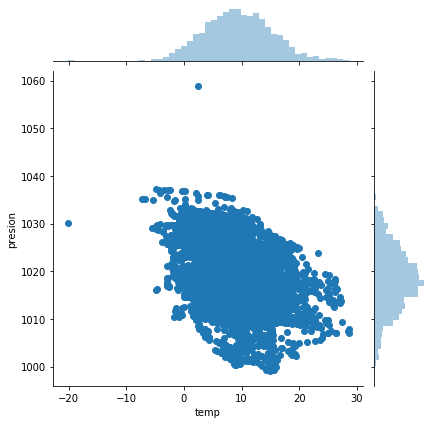

In [190]:
sns.jointplot(x="temp", y="presion", data=weather)

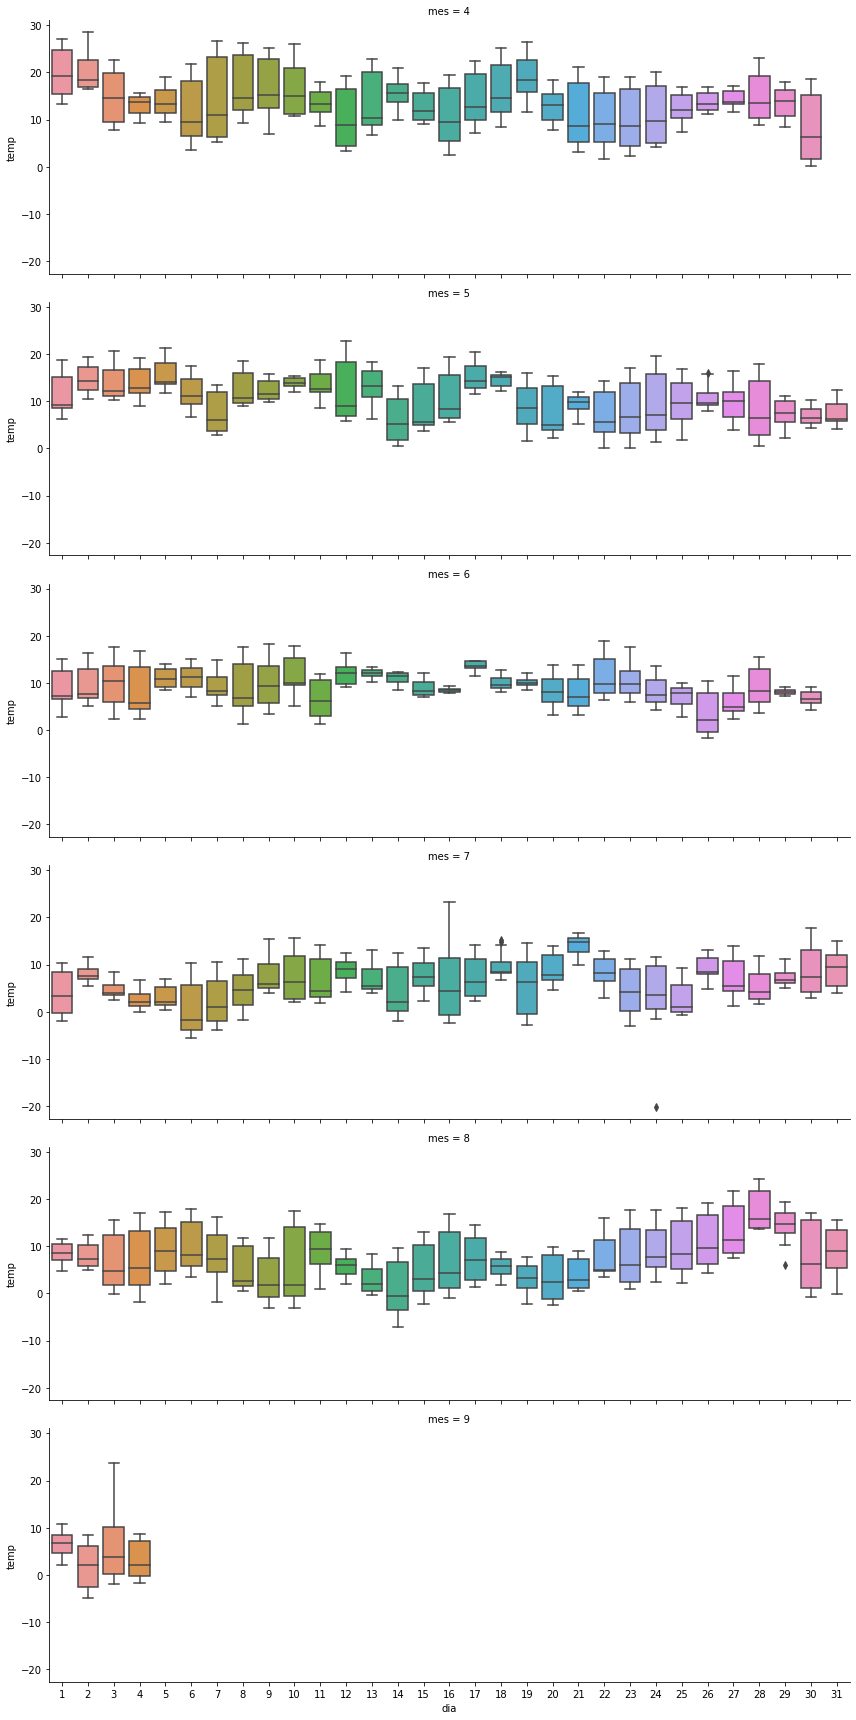

In [196]:
sns.catplot(x="dia", y="temp", row="mes", data=weather, kind="box", aspect=3, height=4)

In [148]:
weather.loc[:, "dia_año"] = weather.index.dayofyear

In [198]:
weather.head()

,temp,hum,presion,dir,vel,nub,prec,t_max,t_min,situacion,faltante,hora,dia,mes,dia_año
fecha,,,,,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,E,14.8,6.0,0.0,28.9,18.7,Nuboso,False,0,1,4,91
2019-04-01 01:00:00,19.2,93.0,1016.7,E,9.4,4.0,0.0,20.1,12.5,Nubes dispersas,False,1,1,4,91
2019-04-01 02:00:00,18.5,95.0,1016.7,E,3.6,0.0,0.0,20.1,12.5,Despejado,False,2,1,4,91
2019-04-01 03:00:00,15.2,96.0,1016.7,S,5.4,0.0,0.0,20.1,12.5,"Despejado, neblina",False,3,1,4,91
2019-04-01 04:00:00,16.2,95.0,1016.3,E,7.6,4.0,0.0,20.1,12.5,"Nubes dispersas, neblina",False,4,1,4,91


In [204]:
numerical = ["temp", "hum", "presion", "vel"]
categorical = ["dir", "nub"]

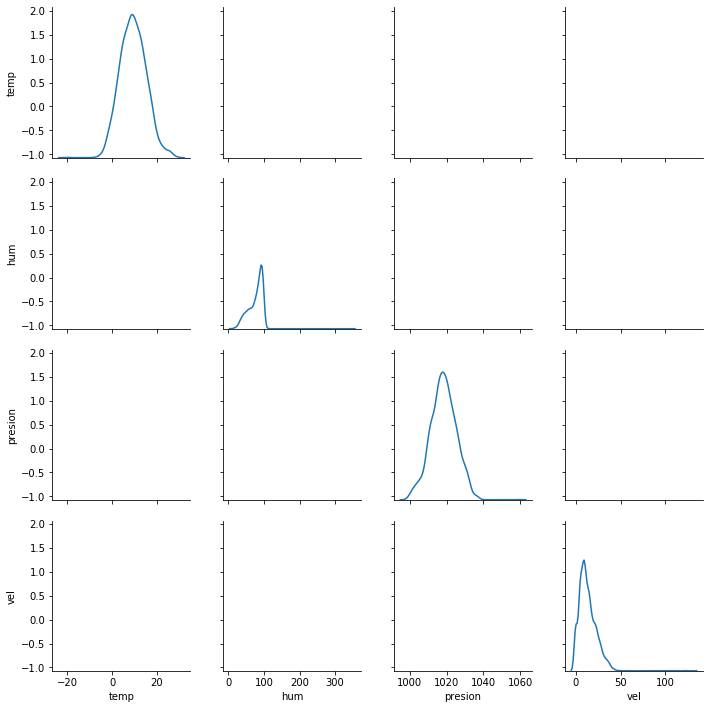

In [202]:
g = sns.PairGrid(weather[numerical])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6)

In [2]:
svc = svm.SVC()

In [ ]:
svc.fit()